# Sprint Seq2Seq

## 1.このSprintについて

**<u>Sprintの目的</u>**

- 系列データに関する応用例を学ぶ

**<u>どのように学ぶか</u>**

公開されているコードを元に学んでいきます。

## 2.機械翻訳

系列データに関する手法の基本的な活用例としては機械翻訳があります。これは系列データを入力し、系列データを出力する **Sequence to Sequence** の手法によって行えます。

## 【問題1】機械翻訳の実行とコードリーディング
以下のサンプルコードは、短い英語からフランス語への変換を行うものです。これを動かしてください。


[keras/lstm_seq2seq.py at master · rstudio/keras](https://github.com/rstudio/keras/blob/master/vignettes/examples/lstm_seq2seq.py)


その上でこのサンプルコードの各部分がどういった役割かを読み取り、まとめてください。以下のようにどこからどこの行が何をしているかを記述してください。


（例）


- 51から55行目 : ライブラリのimport
- 57から62行目 : ハイパーパラメータの設定

**《文字単位のトークン化》**


この実装ではテキストのベクトル化の際に、単語ではなく文字ごとを1つのトークンとして扱っています。


scikit-learnでBoWを計算するCountVectorizerの場合では、デフォルトの引数はanalyzer=’word’で単語を扱いますが、charやchar_wbとすることで文字を扱えるようになります。


charとchar_wbの2種類の方法があり、char_wbを指定した場合、n_gramが単語内からのみ作成されます。逆にcharは単語の区切りが関係なくn_gramが作成されます。This movie is very good.というテキストを3-gramでカウントする時、charではs mやe iといった単語をまたぐ数え方もしますが、char_wbではこれらを見ません。


[sklearn.feature_extraction.text.CountVectorizer — scikit-learn 0.21.3 documentation](https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.CountVectorizer.html)

In [ ]:
# 自分のマイドライブにマウントする

from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


In [ ]:
# カレントディレクトリの変更

import os

os.chdir('/content/drive/MyDrive/Term2_Sprint24_Seq2Seq') 
# os.chdir('../Term2_Sprint24_Seq2Seq') # ローカル環境

# カレントディレクトリの取得
print(os.getcwd())

/content/drive/MyDrive/Term2_Sprint24_Seq2Seq


**機械翻訳の実行**

In [ ]:
'''Sequence to sequence example in Keras (character-level).
This script demonstrates how to implement a basic character-level
sequence-to-sequence model. We apply it to translating
short English sentences into short French sentences,
character-by-character. Note that it is fairly unusual to
do character-level machine translation, as word-level
models are more common in this domain.
# Summary of the algorithm:
- We start with input sequences from a domain (e.g. English sentences)
    and correspding target sequences from another domain
    (e.g. French sentences).
- An encoder LSTM turns input sequences to 2 state vectors
    (we keep the last LSTM state and discard the outputs).
- A decoder LSTM is trained to turn the target sequences into
    the same sequence but offset by one timestep in the future,
    a training process called "teacher forcing" in this context.
    Is uses as initial state the state vectors from the encoder.
    Effectively, the decoder learns to generate `targets[t+1...]`
    given `targets[...t]`, conditioned on the input sequence.
- In inference mode, when we want to decode unknown input sequences, we:
    - Encode the input sequence into state vectors
    - Start with a target sequence of size 1
        (just the start-of-sequence character)
    - Feed the state vectors and 1-char target sequence
        to the decoder to produce predictions for the next character
    - Sample the next character using these predictions
        (we simply use argmax).
    - Append the sampled character to the target sequence
    - Repeat until we generate the end-of-sequence character or we
        hit the character limit.
# Data download:
English to French sentence pairs.
https://www.manythings.org/anki/fra-eng.zip
Lots of neat sentence pairs datasets can be found at:
https://www.manythings.org/anki/
# References:
- Sequence to Sequence Learning with Neural Networks
    https://arxiv.org/abs/1409.3215
- Learning Phrase Representations using
    RNN Encoder-Decoder for Statistical Machine Translation
    https://arxiv.org/abs/1406.1078
'''
from __future__ import print_function

from keras.models import Model
from keras.layers import Input, LSTM, Dense
import numpy as np

batch_size = 64  # Batch size for training.
epochs = 100  # Number of epochs to train for.
latent_dim = 256  # Latent dimensionality of the encoding space.
num_samples = 10000  # Number of samples to train on.
# Path to the data txt file on disk.
data_path = '../Term2_Sprint24_Seq2Seq/fra-eng/fra.txt'

# Vectorize the data. # データのベクトル化
input_texts = []
target_texts = []
input_characters = set()
target_characters = set()
lines = open(data_path).read().split('\n')

for line in lines[: min(num_samples, len(lines) - 1)]:
    input_text, target_text, _ = line.split('\t') # ValueError: too many values to unpack (expected 2) -> 「, _」を追加
    # We use "tab" as the "start sequence" character
    # for the targets, and "\n" as "end sequence" character.
    target_text = '\t' + target_text + '\n'
    input_texts.append(input_text)
    target_texts.append(target_text)
    for char in input_text:
        if char not in input_characters:
            input_characters.add(char)
    for char in target_text:
        if char not in target_characters:
            target_characters.add(char)

input_characters = sorted(list(input_characters))
target_characters = sorted(list(target_characters))
num_encoder_tokens = len(input_characters)
num_decoder_tokens = len(target_characters)
max_encoder_seq_length = max([len(txt) for txt in input_texts])
max_decoder_seq_length = max([len(txt) for txt in target_texts])

print('Number of samples:', len(input_texts))
print('Number of unique input tokens:', num_encoder_tokens)
print('Number of unique output tokens:', num_decoder_tokens)
print('Max sequence length for inputs:', max_encoder_seq_length)
print('Max sequence length for outputs:', max_decoder_seq_length)

input_token_index = dict(
    [(char, i) for i, char in enumerate(input_characters)])
target_token_index = dict(
    [(char, i) for i, char in enumerate(target_characters)])

encoder_input_data = np.zeros(
    (len(input_texts), max_encoder_seq_length, num_encoder_tokens),
    dtype='float32')
decoder_input_data = np.zeros(
    (len(input_texts), max_decoder_seq_length, num_decoder_tokens),
    dtype='float32')
decoder_target_data = np.zeros(
    (len(input_texts), max_decoder_seq_length, num_decoder_tokens),
    dtype='float32')

for i, (input_text, target_text) in enumerate(zip(input_texts, target_texts)):
    for t, char in enumerate(input_text):
        encoder_input_data[i, t, input_token_index[char]] = 1.
    for t, char in enumerate(target_text):
        # decoder_target_data is ahead of decoder_input_data by one timestep
        decoder_input_data[i, t, target_token_index[char]] = 1.
        if t > 0:
            # decoder_target_data will be ahead by one timestep
            # and will not include the start character.
            decoder_target_data[i, t - 1, target_token_index[char]] = 1.

# Define an input sequence and process it. # 入力シーケンスの定義と処理
encoder_inputs = Input(shape=(None, num_encoder_tokens))
encoder = LSTM(latent_dim, return_state=True)
encoder_outputs, state_h, state_c = encoder(encoder_inputs)
# We discard `encoder_outputs` and only keep the states.
encoder_states = [state_h, state_c]

# Set up the decoder, using `encoder_states` as initial state. # 初期状態として encoder_states を使用してデコーダを設定
decoder_inputs = Input(shape=(None, num_decoder_tokens))
# We set up our decoder to return full output sequences,
# and to return internal states as well. We don't use the
# return states in the training model, but we will use them in inference.
decoder_lstm = LSTM(latent_dim, return_sequences=True, return_state=True)
decoder_outputs, _, _ = decoder_lstm(decoder_inputs,
                                     initial_state=encoder_states)
decoder_dense = Dense(num_decoder_tokens, activation='softmax')
decoder_outputs = decoder_dense(decoder_outputs)

# Define the model that will turn
# `encoder_input_data` & `decoder_input_data` into `decoder_target_data`
# encoder_input_data & decoder_input_data を - decoder_target_data に変換するモデルを定義
model = Model([encoder_inputs, decoder_inputs], decoder_outputs)

# Run training # モデルの学習
model.compile(optimizer='rmsprop', loss='categorical_crossentropy')
model.fit([encoder_input_data, decoder_input_data], decoder_target_data,
          batch_size=batch_size,
          epochs=epochs,
          validation_split=0.2)
# Save model # モデルの保存
model.save('s2s.h5')

# Next: inference mode (sampling). # 推論モード（サンプリング）
# Here's the drill:
# 1) encode input and retrieve initial decoder state
# 2) run one step of decoder with this initial state
# and a "start of sequence" token as target.
# Output will be the next target token
# 3) Repeat with the current target token and current states

# Define sampling models # サンプリングモデルの定義
encoder_model = Model(encoder_inputs, encoder_states)

decoder_state_input_h = Input(shape=(latent_dim,))
decoder_state_input_c = Input(shape=(latent_dim,))
decoder_states_inputs = [decoder_state_input_h, decoder_state_input_c]
decoder_outputs, state_h, state_c = decoder_lstm(
    decoder_inputs, initial_state=decoder_states_inputs)
decoder_states = [state_h, state_c]
decoder_outputs = decoder_dense(decoder_outputs)
decoder_model = Model(
    [decoder_inputs] + decoder_states_inputs,
    [decoder_outputs] + decoder_states)

# Reverse-lookup token index to decode sequences back to
# something readable.
# トークンインデックスを逆引きして、シーケンスをデコード、出力
reverse_input_char_index = dict(
    (i, char) for char, i in input_token_index.items())
reverse_target_char_index = dict(
    (i, char) for char, i in target_token_index.items())


def decode_sequence(input_seq):
    # Encode the input as state vectors.
    states_value = encoder_model.predict(input_seq)

    # Generate empty target sequence of length 1.
    target_seq = np.zeros((1, 1, num_decoder_tokens))
    # Populate the first character of target sequence with the start character.
    target_seq[0, 0, target_token_index['\t']] = 1.

    # Sampling loop for a batch of sequences
    # (to simplify, here we assume a batch of size 1).
    stop_condition = False
    decoded_sentence = ''
    while not stop_condition:
        output_tokens, h, c = decoder_model.predict(
            [target_seq] + states_value)

        # Sample a token
        sampled_token_index = np.argmax(output_tokens[0, -1, :])
        sampled_char = reverse_target_char_index[sampled_token_index]
        decoded_sentence += sampled_char

        # Exit condition: either hit max length
        # or find stop character.
        if (sampled_char == '\n' or
           len(decoded_sentence) > max_decoder_seq_length):
            stop_condition = True

        # Update the target sequence (of length 1).
        target_seq = np.zeros((1, 1, num_decoder_tokens))
        target_seq[0, 0, sampled_token_index] = 1.

        # Update states
        states_value = [h, c]

    return decoded_sentence


for seq_index in range(100):
    # Take one sequence (part of the training test)
    # for trying out decoding.
    input_seq = encoder_input_data[seq_index: seq_index + 1]
    decoded_sentence = decode_sequence(input_seq)
    print('-')
    print('Input sentence:', input_texts[seq_index])
    print('Decoded sentence:', decoded_sentence)

Number of samples: 10000
Number of unique input tokens: 71
Number of unique output tokens: 93
Max sequence length for inputs: 15
Max sequence length for outputs: 59
Epoch 1/100
125/125 [==============================] - 53s 400ms/step - loss: 1.0341 - val_loss: 1.0775
Epoch 2/100
125/125 [==============================] - 48s 384ms/step - loss: 0.9273 - val_loss: 1.0341
Epoch 3/100
125/125 [==============================] - 48s 384ms/step - loss: 0.8761 - val_loss: 0.9908
Epoch 4/100
125/125 [==============================] - 48s 383ms/step - loss: 0.8344 - val_loss: 0.9132
Epoch 5/100
125/125 [==============================] - 48s 383ms/step - loss: 0.7982 - val_loss: 0.8895
Epoch 6/100
125/125 [==============================] - 48s 386ms/step - loss: 0.7778 - val_loss: 0.8735
Epoch 7/100
125/125 [==============================] - 48s 386ms/step - loss: 0.7527 - val_loss: 0.8864
Epoch 8/100
125/125 [==============================] - 49s 390ms/step - loss: 0.7374 - val_loss: 0.8229
Epo

**コードリーディング（行数は公式Githubに合わせる）**

- 51から55行目 : ライブラリのimport
- 57から62行目 : ハイパーパラメータの設定
- 64から121行目 :  データのベクトル化
- 123から128行目 :  入力シーケンスの定義と処理
- 130から139行目 :  初期状態として `encoder_states` を使用してデコーダを設定
- 141から143行目 :  `encoder_input_data` & `decoder_input_data` を - `decoder_target_data` に変換するモデルを定義
- 145から150行目 :  モデルの学習
- 151から152行目 :  モデルの保存
- 154から         :  推論モード（サンプリング）
- 162から174行目 : サンプリングモデルの定義
- 176から         :  トークンインデックスを逆引きして、シーケンスをデコード、出力

## 3.イメージキャプショニング

他の活用例としてイメージキャプショニングがあります。画像に対する説明の文章を推定するタスクです。これは画像を入力し、系列データを出力する **Image to Sequence** の手法によって行えます。


[pytorch-tutorial/tutorials/03-advanced/image_captioning at master · yunjey/pytorch-tutorial](https://github.com/yunjey/pytorch-tutorial/tree/master/tutorials/03-advanced/image_captioning)


イメージキャプショニングは学習に多くの時間がかかるため、ここでは学習済みの重みが公開されている実装を動かすことにします。Kerasには平易に扱える実装が公開されていないため、今回はPyTorchによる実装を扱います。

## 【問題2】イメージキャプショニングの学習済みモデルの実行

上記実装において **5. Test the model** の項目を実行してください。また、自身で用意した画像に対しても文章を生成してください。これらに対してどういった文章が出力されたかを記録して提出してください。


データセットからの学習は行わず、学習済みの重みをダウンロードして利用します。


注意点として、デフォルトで設定されている重みのファイル名と、ダウンロードできる重みのファイル名は異なっています。ここは書き換える必要があります。

In [ ]:
!git clone https://github.com/yunjey/pytorch-tutorial.git

Cloning into 'pytorch-tutorial'...
remote: Enumerating objects: 917, done.
remote: Total 917 (delta 0), reused 0 (delta 0), pack-reused 917
Receiving objects: 100% (917/917), 12.80 MiB | 14.83 MiB/s, done.
Resolving deltas: 100% (490/490), done.


In [ ]:
cd pytorch-tutorial/tutorials/03-advanced/image_captioning/

/content/drive/MyDrive/Term2_Sprint24_Seq2Seq/pytorch-tutorial/tutorials/03-advanced/image_captioning


In [ ]:
!python sample.py --image='png/example.png'

<start> a group of giraffes standing next to each other . <end>


In [ ]:
from google.colab import files
uploaded = files.upload()

Saving example.png to example.png


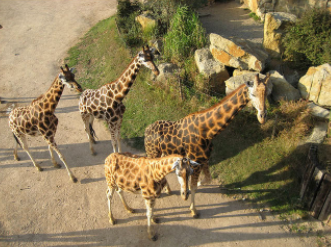

In [ ]:
from IPython.display import Image,display_png
display_png(Image('example.png'))

In [ ]:
! python sample.py --image='png/cat02.jpg'

<start> a close up of a cat looking at a camera <end>


In [ ]:
uploaded = files.upload()

Saving cat02.jpg to cat02.jpg


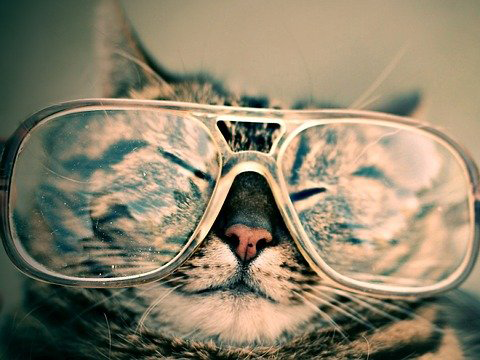

In [ ]:
from IPython.display import Image,display_jpeg
display_jpeg(Image('cat02.jpg'))

In [ ]:
! python sample.py --image='png/dog03.jpg'

<start> a small dog is sitting on a table with a cell phone . <end>


In [ ]:
uploaded = files.upload()

Saving dog03.jpg to dog03.jpg


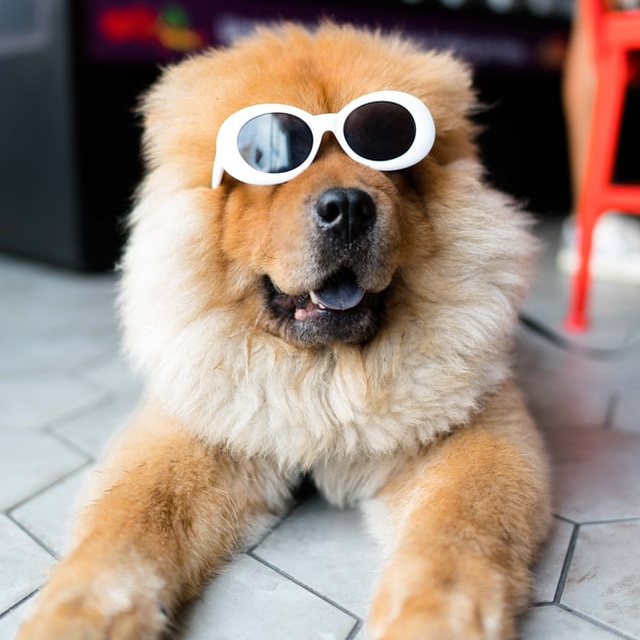

In [ ]:
display_jpeg(Image('dog03.jpg'))

## 【問題3】Kerasで動かしたい場合はどうするかを調査
PyTorchによる実装を動かしましたが、何らかの理由からKerasで動かしたい状況が考えられます。どういった手順を踏むことになるか調査し、できるだけ詳しく説明してください。


特に今回はPyTorchのための学習済みの重みをKerasで使えるようにしたいので、その点については必ず触れてください。

**相互変換ツールMMdnnを使用する方法**

> <u>MMdnnとは？</u>

> Microsoft Researchにより開発が進められているオープンソースの深層学習モデルの変換と可視化を行うツールです。中間表現を経由することで様々なフレームワーク間でのモデルデータの相互変換を実現しています。

(参考記事)[深層学習モデルの相互変換ツールMMdnnを試す](https://qiita.com/koppe/items/7f85f5411539390c4499)

> **pytorch -> onnx -> tensorflow(.pbファイル)**

> モデルの変換
- PyTorch -> onnx
- onnx -> tensorflow


> モデルの変換処理

    $ mmconvert -sf keras -iw imagenet_inception_v3.h5 -df onnx -om imagenet_inception_v3.onnx

> 実行すると「imagenet_inception_v3.h5」というkerasモデルファイルに対して、「imagenet_inception_v3.onnx」というファイルが生成されます。

    MMdnn/mmdnn/conversion/_script/convert.py

- -sf [framework]・・・・変換元(sauce)のフレームワーク
- -iw [ファイル]・・・・・入力する重みファイル
- -in [ファイル]・・・・・入力するネットワークファイル
- -df [framework]・・・・変換先(destination)フレームワーク
- -om [ファイル]・・・・・出力先のモデルファイル名

※入力する学習済み重みファイルは別途変換する必要があるようです。

(参考記事)[pytorchのモデルをtfliteに変換する](https://qiita.com/yasudadesu/items/71988fca3a8b7a859c1a)

**pytorch2kerasを使用する方法**

> **API**
Here is the only method pytorch_to_keras from pytorch2keras module.

     def pytorch_to_keras(
        model, args, input_shapes=None,
        change_ordering=False, verbose=False, name_policy=None,
      ):

Options:

- model - a PyTorch model (nn.Module) to convert;
- args - a list of dummy variables with proper shapes;
- input_shapes - (experimental) list with overrided shapes for 
inputs;
- change_ordering - (experimental) boolean, if enabled, the - converter will try to change BCHW to BHWC
- verbose - boolean, detailed log of conversion
- name_policy - (experimental) choice from [keep, short, random]. - The selector set the target layer naming policy.

**Supported layers**

- Activations:

  - ReLU
  - LeakyReLU
  - SELU
  - Sigmoid
  - Softmax
  - Tanh

- Constants

- Convolutions:

  - Conv2d
  - ConvTrsnpose2d

- Element-wise:

  - Add
  - Mul
  - Sub
  - Div

- Linear

- Normalizations:

  - BatchNorm2d
  - InstanceNorm2d

- Poolings:

  - MaxPool2d
  - AvgPool2d
  - Global MaxPool2d (adaptive pooling to shape [1, 1])

(公式Github)[PyTorch to Keras model converter.](https://github.com/nerox8664/pytorch2keras)